In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# !pip install bokeh

#https://www.kaggle.com/neerjad/time-series-visualization-using-bokeh

In [3]:
# dataset = read_csv('row.csv')
# dataset.head()

In [4]:
# # consolidate the date-time information into a single date-time

# from pandas import read_csv
# from datetime import datetime

# # load data
# def parse(x):
#     return datetime.strptime(x, '%Y %m %d %H')


# dataset = read_csv('row.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
# dataset.drop('No', axis=1, inplace=True)

# # manually specify column names
# dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
# dataset.index.name = 'date'

# # mark all NA values with 0
# dataset['pollution'].fillna(0, inplace=True)

# # drop the first 24 hours
# dataset = dataset[24:]

# # summarize first 5 rows
# print(dataset.head(5))

# # save to file
# dataset.to_csv('pollution.csv')

In [5]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [9]:
# dataset.info()

In [8]:
# dataset.wnd_dir.unique()

In [11]:
values = dataset.values
values[0]

array([129.0, -16, -4.0, 1020.0, 'SE', 1.79, 0, 0], dtype=object)

In [12]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

values[0]

array([129.0, -16, -4.0, 1020.0, 2, 1.79, 0, 0], dtype=object)

In [13]:

# ensure all data is float
values = values.astype('float32')

In [15]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
values[:5]

array([[ 1.290e+02, -1.600e+01, -4.000e+00,  1.020e+03,  2.000e+00,
         1.790e+00,  0.000e+00,  0.000e+00],
       [ 1.480e+02, -1.500e+01, -4.000e+00,  1.020e+03,  2.000e+00,
         2.680e+00,  0.000e+00,  0.000e+00],
       [ 1.590e+02, -1.100e+01, -5.000e+00,  1.021e+03,  2.000e+00,
         3.570e+00,  0.000e+00,  0.000e+00],
       [ 1.810e+02, -7.000e+00, -5.000e+00,  1.022e+03,  2.000e+00,
         5.360e+00,  1.000e+00,  0.000e+00],
       [ 1.380e+02, -7.000e+00, -5.000e+00,  1.022e+03,  2.000e+00,
         6.250e+00,  2.000e+00,  0.000e+00]], dtype=float32)

In [18]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

scaled[:5]

array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ],
       [0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
        0.00533197, 0.        , 0.        ],
       [0.18209255, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00839101, 0.03703704, 0.        ],
       [0.13883299, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00991199, 0.07407407, 0.        ]], dtype=float32)

In [29]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [30]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [45]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24

In [46]:
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [47]:

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 8) (8760,) (35039, 8) (35039,)


In [48]:
train_X[:5]

array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ],
       [0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
        0.00533197, 0.        , 0.        ],
       [0.18209255, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00839101, 0.03703704, 0.        ],
       [0.13883299, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00991199, 0.07407407, 0.        ]], dtype=float32)

In [49]:

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [50]:
train_X[:5]

array([[[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
         0.00229001, 0.        , 0.        ]],

       [[0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
         0.00381099, 0.        , 0.        ]],

       [[0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
         0.00533197, 0.        , 0.        ]],

       [[0.18209255, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
         0.00839101, 0.03703704, 0.        ]],

       [[0.13883299, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
         0.00991199, 0.07407407, 0.        ]]], dtype=float32)

# Hyperparams

In [53]:
# Number of Epochs
epochs = 10
# Batch Size
batch_size = 512
# RNN Size
rnn_size = 128
# Number of Layers
num_layers = 2
# Embedding Size
encoding_embedding_size = 128
decoding_embedding_size = 128
# Learning Rate
learning_rate = 0.001
# Dropout Keep Probability
keep_probability = 0.55
display_step = True

In [54]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0622 - val_loss: 0.0512
Epoch 2/50
 - 0s - loss: 0.0415 - val_loss: 0.0514
Epoch 3/50
 - 1s - loss: 0.0259 - val_loss: 0.0409
Epoch 4/50
 - 0s - loss: 0.0171 - val_loss: 0.0289
Epoch 5/50
 - 0s - loss: 0.0149 - val_loss: 0.0164
Epoch 6/50
 - 0s - loss: 0.0147 - val_loss: 0.0151
Epoch 7/50
 - 0s - loss: 0.0148 - val_loss: 0.0148
Epoch 8/50
 - 0s - loss: 0.0147 - val_loss: 0.0143
Epoch 9/50
 - 0s - loss: 0.0146 - val_loss: 0.0141
Epoch 10/50
 - 0s - loss: 0.0147 - val_loss: 0.0139
Epoch 11/50
 - 0s - loss: 0.0145 - val_loss: 0.0137
Epoch 12/50
 - 0s - loss: 0.0146 - val_loss: 0.0135
Epoch 13/50
 - 0s - loss: 0.0145 - val_loss: 0.0137
Epoch 14/50
 - 0s - loss: 0.0146 - val_loss: 0.0136
Epoch 15/50
 - 0s - loss: 0.0145 - val_loss: 0.0135
Epoch 16/50
 - 1s - loss: 0.0145 - val_loss: 0.0135
Epoch 17/50
 - 0s - loss: 0.0145 - val_loss: 0.0135
Epoch 18/50
 - 0s - loss: 0.0146 - val_loss: 0.0133
Epoch 19/50
 - 0s - loss

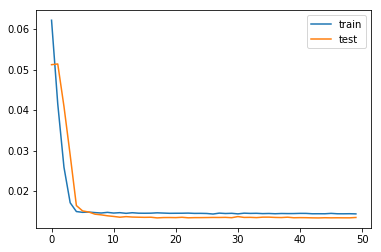

In [55]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [56]:
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [57]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [58]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.496


# Ref

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
